In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map

Setup

In [2]:
leaky_relu = LeakyReLU(alpha=0.01)

class CONFIG:
    def __init__(self):
        CONFIG.layer_1 = 12
        CONFIG.activation_1 = leaky_relu
        CONFIG.dropout = random.uniform(0.01, 0.80)
        CONFIG.layer_2 = 10
        CONFIG.activation_2 = "relu"
        CONFIG.layer_3 = 7
        CONFIG.optimizer = "adam"
        CONFIG.loss = "mae"
        CONFIG.metric = "accuracy"
        CONFIG.epoch = 6
        CONFIG.batch_size = 32


config = CONFIG()


def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer


def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=32):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds


def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()



Import data

In [3]:

pulse_data = pd.read_csv("../JET_EFIT_magnetic/sampled_data.csv")
pulse_data = pulse_data.dropna(axis=0)

y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)



Check statistics

In [7]:
print(pulse_data.describe().transpose()[['mean', 'std']])


              mean       std
FAXS      0.120420  0.822241
FBND      0.885580  0.914039
Time     52.410838  8.295095
BPME_13  -0.022851  0.245345
BPME_17  -0.042618  0.205164
FLME_19  -0.042366  0.117462
BPME_9   -0.014746  0.195419
FLME_17   0.008846  0.094223
BPME_15  -0.035088  0.171885
BPME_6    0.028976  0.403662
FLME_14  -0.008491  0.080167
BPME_1   -0.000458  0.012762
FLME_12  -0.028657  0.166699
BPME_4    0.002834  0.131903
BPME_18  -0.040777  0.129938
BPME_7    0.004489  0.088617
FLME_13  -0.025188  0.086453
BPME_3   -0.001670  0.035347
FLME_9   -0.055496  0.193025
FLME_10  -0.017101  0.053852
FLME_38   0.026728  0.274919
BPME_11  -0.032423  0.186289
FLME_8   -0.007432  0.024769
FLME_20   0.024980  0.110418
FLME_11   0.000630  0.060033
FLME_18  -0.024818  0.129153
FLME_16  -0.028436  0.093404
BPME_5   -0.001269  0.016878
BPME_0   -0.000052  0.000416
BPME_12  -0.024841  0.246943
BPME_16  -0.046941  0.190630
FLME_7   -0.026231  0.135816
BPME_8    0.001054  0.136794
FLME_15  -0.01

Preprocessing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)


print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

print(type(X_train))
print(type(X))

print(X_train.describe().transpose()[['mean', 'std']])


236 train examples
60 validation examples
74 test examples
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
             mean       std
BPME_13 -0.025093  0.262644
BPME_17 -0.049616  0.228944
FLME_19 -0.046424  0.118706
BPME_9  -0.024260  0.229347
FLME_17  0.006926  0.092070
BPME_15 -0.045869  0.166465
BPME_6   0.020864  0.357395
FLME_14 -0.008120  0.079468
BPME_1  -0.000734  0.010042
FLME_12 -0.028860  0.163478
BPME_4   0.008301  0.159686
BPME_18 -0.043399  0.149357
BPME_7   0.007439  0.092452
FLME_13 -0.019919  0.086224
BPME_3  -0.000501  0.028762
FLME_9  -0.063998  0.199741
FLME_10 -0.016106  0.053617
FLME_38  0.017232  0.271997
BPME_11 -0.044247  0.225500
FLME_8  -0.008135  0.025003
FLME_20  0.023486  0.113627
FLME_11 -0.000674  0.061553
FLME_18 -0.017184  0.126390
FLME_16 -0.024307  0.096293
BPME_5  -0.000351  0.019276
BPME_0  -0.000056  0.000427
BPME_12 -0.012679  0.213829
BPME_16 -0.054119  0.215216
FLME_7  -0.022734  0.130048
BPME_8   0.001445  0.1295

Setup model

In [5]:

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(40, input_dim=35),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)

print(model.summary())

model.compile(
    optimizer="adam", loss="mae", metrics="mape",
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1440      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 2,470
Trainable params: 2,470
Non-trainable params: 0
_________________________________________________________________
None


Train model

In [6]:
num_epochs = 100
# Not worried about memory or local minima
batchSize = len(X_train)

# Train on data
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batchSize,
    epochs=num_epochs,
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.6939 - mape: 111.3654 - val_loss: 0.7050 - val_mape: 103.9071
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.6925 - mape: 110.7993 - val_loss: 0.7044 - val_mape: 103.7090
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6910 - mape: 110.2546 - val_loss: 0.7038 - val_mape: 103.6200
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6897 - mape: 109.8143 - val_loss: 0.7032 - val_mape: 103.5994
Epoch 5/100
1/1 [==============================] - 0s 26ms/step - loss: 0.6883 - mape: 109.3641 - val_loss: 0.7027 - val_mape: 103.6136
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.6870 - mape: 108.9282 - val_loss: 0.7023 - val_mape: 103.6501
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.6856 - mape: 108.5067 - val_loss: 0.7020 - val_mape: 103.6979
Epoch 8/100
1/1 [==============================] -

1/1 [==============================] - 0s 57ms/step - loss: 0.6341 - mape: 93.8679 - val_loss: 0.7153 - val_mape: 116.0104
Epoch 62/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6332 - mape: 93.7393 - val_loss: 0.7158 - val_mape: 116.4039
Epoch 63/100
1/1 [==============================] - 0s 41ms/step - loss: 0.6322 - mape: 93.5894 - val_loss: 0.7163 - val_mape: 116.7575
Epoch 64/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6312 - mape: 93.4143 - val_loss: 0.7168 - val_mape: 117.1117
Epoch 65/100
1/1 [==============================] - 0s 54ms/step - loss: 0.6303 - mape: 93.2308 - val_loss: 0.7174 - val_mape: 117.4358
Epoch 66/100
1/1 [==============================] - 0s 44ms/step - loss: 0.6293 - mape: 93.0474 - val_loss: 0.7179 - val_mape: 117.7283
Epoch 67/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6283 - mape: 92.8386 - val_loss: 0.7184 - val_mape: 117.9930
Epoch 68/100
1/1 [==============================] - 0s 46ms/s

Plot loss

2/2 - 0s - loss: 0.7162 - mae: 0.7162


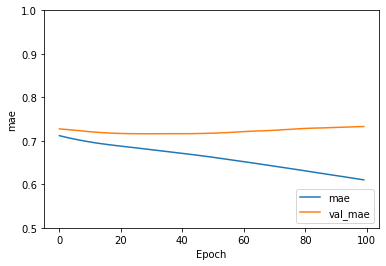

In [18]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(X_val,  y_val, verbose=2)